### Imports

In [113]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from math import sqrt
from itertools import product
from time import time
from collections import Counter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Differences between squares

### Various functions

Euclidean distance between 2 points on a grid

In [8]:
def euclidean_dictance(x1, y1, x2, y2):
    return sqrt((x1 - x2)**2 + (y1 - y2)**2)

Build a grid of squares of given size tiling a 512x512 image (the `size` parameter is length of the squares' side in pixels). With this kind of grid we know where each of the squares is situated from its number, and can calculate distances

In [29]:
def build_square(size=16):
    side_length = 512//size
    pointdict = {}
    x = 0
    for i in range(side_length):
        for j in range(side_length):
            pointdict[x] = (j, i)
            x += 1
    return pointdict

For a given min and max distance, get all points on the grid that are within [min, max) range from a certain point

In [31]:
def get_points_within_range(pointdict, number, min_dist, max_dist):
    x, y = pointdict[number]
    goodpts = []
    for pt in pointdict:
        if (euclidean_dictance(x, y, pointdict[pt][0], pointdict[pt][1]) < max_dist and
            euclidean_dictance(x, y, pointdict[pt][0], pointdict[pt][1]) >= min_dist):
            goodpts.append(pt)
    return goodpts

For each pair of points on a grid, calculate euclidean distance between them

In [36]:
def distances_dictionary(pointdict):
    pairs = [t for t in list(product(pointdict, pointdict)) if t[0]!=t[1]]
    distances_dict = {}
    for pair in pairs:
        distances_dict[pair] = euclidean_dictance(pointdict[pair[0]][0],
                                                  pointdict[pair[0]][1],
                                                  pointdict[pair[1]][0],
                                                  pointdict[pair[1]][1])
    return distances_dict

Given a dict of distances between pairs of points, bin pairs into ranges like [1, 2) etc.

In [37]:
def pairs_per_range(distdict):
    max_distance = int(max(list(distdict.values()))) + 1
    pairs_by_range = {(i, i+1): [] for i in range(max_distance)}
    for pair in distdict:
        pairs_by_range[(int(distdict[pair]), int(distdict[pair]) + 1)].append(pair)
    return pairs_by_range        

Calculate RMSE between 2 arrays

In [1]:
def rmse(ar1, ar2):
    return np.sqrt(np.mean(np.subtract(ar1, ar2)**2))

Calculate mean and median RMSE between pairs which fall into each distance range

In [39]:
def average_per_range(pairs_per_range_dict, pointdict, df):
    averages_dict = {distance_range: None for
                     distance_range in pairs_per_range_dict}
    for distance_range in pairs_per_range_dict:
        print(distance_range, end=' ')
        averages_dict[distance_range] = np.mean([rmse(ar1=df['mean_sq{}'.format(point_pair[0])],
                                                      ar2=df['mean_sq{}'.format(point_pair[1])]) for
                                                 point_pair in pairs_per_range_dict[distance_range]])
    return averages_dict

In [40]:
def median_per_range(pairs_per_range_dict, pointdict, df):
    medians_dict = {distance_range: None for
                    distance_range in pairs_per_range_dict}
    for distance_range in pairs_per_range_dict:
        print(distance_range, end=' ')
        medians_dict[distance_range] = np.median([rmse(ar1=df['mean_sq{}'.format(point_pair[0])],
                                                      ar2=df['mean_sq{}'.format(point_pair[1])]) for
                                                 point_pair in pairs_per_range_dict[distance_range]])
    return medians_dict

A special error measure for RMSE in time prediction, so that we don't have errors greater than 12 hours

In [2]:
def rmse_time(predicted, actual):
    return np.sqrt(np.mean(np.minimum(np.abs(np.subtract(predicted, actual)), np.abs(np.subtract(predicted, actual) - 24))**2))

### Test things out visually

Build an 8x8 grid

In [5]:
pointdict = {}
x = 0
for i in range(8):
    for j in range(8):
        pointdict[(i, j)] = x
        x += 1

Same thing in a list instead of a dict

In [6]:
pointlist = []
x = 0
for i in range(8):
    for j in range(8):
        pointlist.append([i, j, x])
        x += 1

Plot the small grid, point 28 marked red

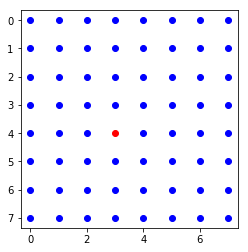

In [7]:
for pt in pointlist:
    if pt[2] == 28:
        plt.plot(pt[0], pt[1], 'ro')
    else:
        plt.plot(pt[0], pt[1], 'bo')
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.show()

Find all points within distance in range [3, 4) from point 0

In [9]:
x, y = 0, 0
badpts = []
goodpts = []
for pt in pointlist:
    if euclidean_dictance(x, y, pt[0], pt[1]) < 4 and euclidean_dictance(x, y, pt[0], pt[1]) >= 3:
        goodpts.append(pt)

Plot those points

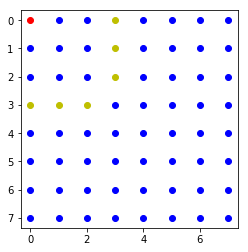

In [10]:
for pt in pointlist:
    if pt[2] == 0:
        plt.plot(pt[0], pt[1], 'ro')
    elif pt in goodpts:
        plt.plot(pt[0], pt[1], 'yo')
    else:
        plt.plot(pt[0], pt[1], 'bo')
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.show()

### Read in a dataframe with means of 16x16 squares per image (calculated with a separate script)

In [178]:
squares16df = pd.read_csv('means16.csv', index_col=0)

In [179]:
squares16df.head(10)

,Image.No.,Frame.No,Time.hrs.,path,loaded,mean_intensity,std_intensity,mean_sq0,mean_sq1,mean_sq2,...,mean_sq1014,mean_sq1015,mean_sq1016,mean_sq1017,mean_sq1018,mean_sq1019,mean_sq1020,mean_sq1021,mean_sq1022,mean_sq1023
0,40,1,3.750892,141110A3.0040,True,2450.778805,413.650524,1713.804688,1755.683594,1786.824219,...,2511.117188,2483.660156,2432.089844,2423.089844,2425.386719,2284.121094,2261.871094,2293.031250,2167.734375,2123.457031
1,44,2,3.846050,141110A3.0044,True,2411.383465,419.041849,1667.105469,1702.195312,1743.519531,...,2491.675781,2465.074219,2417.628906,2409.375000,2396.800781,2256.851562,2240.300781,2271.394531,2143.828125,2097.484375
2,45,3,3.946050,141110A3.0045,True,2393.520092,429.238393,1641.464844,1676.917969,1719.128906,...,2505.089844,2474.414062,2421.132812,2410.882812,2400.734375,2257.105469,2244.863281,2276.769531,2148.519531,2100.277344
3,46,4,4.046050,141110A3.0046,True,2350.644688,433.929205,1594.101562,1632.632812,1666.039062,...,2476.203125,2455.855469,2396.984375,2384.699219,2381.550781,2234.535156,2213.925781,2251.421875,2121.406250,2076.019531
4,47,5,4.146050,141110A3.0047,True,2337.459301,440.732899,1584.234375,1622.046875,1657.960938,...,2483.917969,2463.121094,2415.062500,2399.242188,2387.968750,2246.507812,2223.867188,2251.546875,2127.738281,2079.640625
5,48,6,4.246050,141110A3.0048,True,2321.926811,447.106610,1566.968750,1611.007812,1640.265625,...,2494.757812,2483.539062,2427.414062,2404.511719,2399.113281,2249.539062,2230.175781,2249.601562,2132.796875,2090.785156
6,49,7,4.346050,141110A3.0049,True,2291.294880,448.767757,1545.867188,1588.625000,1619.781250,...,2482.074219,2462.796875,2412.718750,2388.820312,2385.035156,2230.914062,2213.585938,2236.273438,2128.183594,2079.140625
7,50,8,4.446050,141110A3.0050,True,2298.530254,457.515413,1549.269531,1594.113281,1627.222656,...,2504.945312,2503.019531,2449.750000,2417.253906,2414.019531,2261.859375,2241.136719,2257.933594,2150.132812,2107.847656
8,51,9,4.546050,141110A3.0051,True,2295.872921,462.988079,1548.339844,1588.753906,1624.964844,...,2532.027344,2522.871094,2461.507812,2429.117188,2438.574219,2270.859375,2245.652344,2264.460938,2163.867188,2114.503906
9,52,10,4.646050,141110A3.0052,True,2287.554661,467.284781,1544.527344,1581.562500,1613.261719,...,2543.199219,2537.265625,2477.835938,2448.984375,2447.734375,2280.867188,2253.906250,2269.226562,2170.507812,2126.515625


Process the dataframe with functions from the previous section so that we can measure differences between squares

In [23]:
squares16dict = build_square(size=16)

In [24]:
squares16distances = distances_dictionary(squares16dict)

In [25]:
squares16byrange = pairs_per_range(squares16distances)

In [26]:
# this was taking long, did a printout to see the progress
# since logging does not work here for some reason
start = time()
squares16averages = average_per_range(df=squares16df,
                                      pairs_per_range_dict=squares16byrange,
                                      pointdict=squares16dict)
print(time() - start)

(7, 8) (10, 11) (40, 41) (39, 40) (5, 6) (8, 9) (18, 19) (22, 23) (31, 32) (19, 20) (1, 2) (6, 7) (12, 13) (11, 12) (27, 28) (25, 26) (28, 29) (4, 5) (0, 1) (20, 21) 

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(35, 36) (36, 37) (32, 33) (16, 17) (42, 43) (29, 30) (15, 16) (9, 10) (2, 3) (26, 27) (37, 38) (23, 24) (33, 34) (41, 42) (38, 39) (21, 22) (17, 18) (24, 25) (13, 14) (14, 15) (43, 44) (30, 31) (3, 4) (34, 35) 520.1669864654541


Plot the average RMSE's

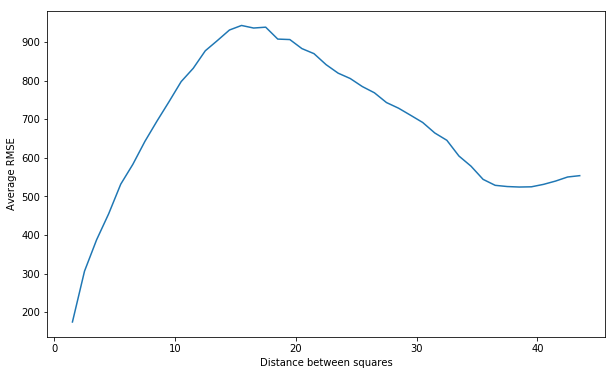

In [102]:
plt.figure(figsize=(10,6))
plt.plot([np.mean(key) for key in sorted(squares16averages)], [squares16averages[key] for key in sorted(squares16averages)])
# plt.title('Average RMSE of all square pairs with given distance of each other')
plt.xlabel('Distance between squares')
plt.ylabel('Average RMSE')
plt.savefig('rmse.png')
plt.show()

Check the numbers

In [63]:
for key in sorted(squares16averages):
    print(np.mean(key), squares16averages[key])

0.5 nan
1.5 175.331497068
2.5 306.817006331
3.5 387.90503444
4.5 455.224744377
5.5 531.892269741
6.5 583.062144214
7.5 642.524663683
8.5 695.05582052
9.5 745.370669177
10.5 797.11320185
11.5 831.553722068
12.5 876.954908326
13.5 903.385351335
14.5 930.656920157
15.5 942.426199833
16.5 935.782183742
17.5 938.005920637
18.5 907.179006225
19.5 905.968561141
20.5 882.559744683
21.5 869.492558536
22.5 841.076093288
23.5 819.02779807
24.5 805.177050304
25.5 784.407844981
26.5 768.291551362
27.5 743.008822678
28.5 728.409619958
29.5 710.084674259
30.5 691.442188787
31.5 664.30393446
32.5 645.341596793
33.5 604.683833943
34.5 578.409832777
35.5 544.273353532
36.5 528.859923568
37.5 525.713029132
38.5 524.435590298
39.5 525.025294661
40.5 531.305526348
41.5 539.854682911
42.5 550.410151632
43.5 553.860727218


Check that indexing is right and look at points which are in further away pairs

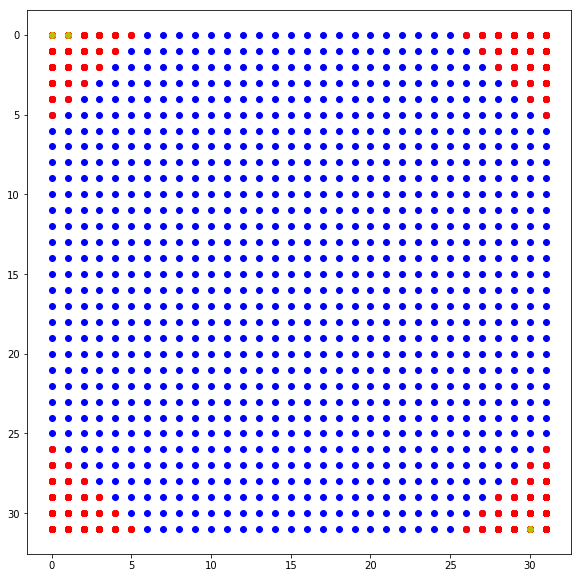

In [28]:
plt.figure(figsize=(10,10))
for pt in squares16dict:
    plt.plot(squares16dict[pt][0], squares16dict[pt][1], 'bo')
for pair in squares16byrange[(40, 41)]:
    for point in pair:
        plt.plot(squares16dict[point][0], squares16dict[point][1], 'ro')
plt.plot(squares16dict[0][0], squares16dict[0][1], 'yo')
plt.plot(squares16dict[1][0], squares16dict[1][1], 'yo')
plt.plot(squares16dict[1022][0], squares16dict[1022][1], 'yo')
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.show()

In [360]:
squares16dict[1022]

(31, 30)

### 8x8 squares

Calculated means for 8x8 squares as well, but they are often too small to capture cells well, and processing this amount of numbers is very time-consuming (but could also be that my code is ineffective)

In [323]:
squares8df = pd.read_csv('means8.csv', index_col=0)

In [324]:
squares8df.head(10)

,Image.No.,Frame.No,Time.hrs.,path,loaded,mean_intensity,std_intensity,mean_sq0,mean_sq1,mean_sq2,...,mean_sq4086,mean_sq4087,mean_sq4088,mean_sq4089,mean_sq4090,mean_sq4091,mean_sq4092,mean_sq4093,mean_sq4094,mean_sq4095
0,40,1,3.750892,141110A3.0040,True,2450.778805,413.650524,1687.203125,1701.625000,1702.906250,...,2243.984375,2236.250000,2224.671875,2230.296875,2303.375000,2228.078125,2168.562500,2114.000000,2093.953125,2063.468750
1,44,2,3.846050,141110A3.0044,True,2411.383465,419.041849,1634.656250,1660.453125,1655.390625,...,2224.796875,2213.468750,2201.453125,2206.187500,2287.406250,2200.609375,2146.500000,2084.359375,2053.859375,2034.484375
2,45,3,3.946050,141110A3.0045,True,2393.520092,429.238393,1609.062500,1632.875000,1626.328125,...,2221.765625,2212.609375,2203.875000,2213.984375,2284.953125,2217.828125,2154.765625,2093.781250,2058.078125,2047.109375
3,46,4,4.046050,141110A3.0046,True,2350.644688,433.929205,1571.328125,1575.484375,1596.656250,...,2203.968750,2194.765625,2184.515625,2184.296875,2255.218750,2211.984375,2126.640625,2070.828125,2038.406250,2008.515625
4,47,5,4.146050,141110A3.0047,True,2337.459301,440.732899,1562.046875,1575.109375,1582.640625,...,2215.687500,2206.093750,2192.796875,2188.343750,2242.250000,2228.796875,2136.031250,2068.968750,2045.968750,2017.968750
5,48,6,4.246050,141110A3.0048,True,2321.926811,447.106610,1536.718750,1557.734375,1582.031250,...,2218.765625,2212.718750,2210.046875,2204.968750,2256.265625,2225.484375,2136.703125,2073.546875,2052.250000,2032.781250
6,49,7,4.346050,141110A3.0049,True,2291.294880,448.767757,1518.859375,1534.921875,1553.468750,...,2212.546875,2191.281250,2186.515625,2186.531250,2240.015625,2238.328125,2133.265625,2066.812500,2043.109375,2027.593750
7,50,8,4.446050,141110A3.0050,True,2298.530254,457.515413,1513.968750,1546.140625,1564.093750,...,2240.796875,2220.328125,2223.078125,2211.187500,2264.437500,2269.375000,2163.812500,2088.093750,2072.968750,2061.125000
8,51,9,4.546050,141110A3.0051,True,2295.872921,462.988079,1509.843750,1546.156250,1561.390625,...,2242.156250,2241.875000,2219.859375,2220.375000,2288.515625,2280.984375,2156.015625,2121.734375,2081.734375,2060.843750
9,52,10,4.646050,141110A3.0052,True,2287.554661,467.284781,1505.843750,1539.312500,1554.984375,...,2260.828125,2254.171875,2236.640625,2224.140625,2285.062500,2285.562500,2171.000000,2113.937500,2091.421875,2080.953125


In [325]:
squares8dict = build_square(size=8)

In [326]:
squares8distances = distances_dictionary(squares8dict)

In [327]:
squares8byrange = pairs_per_range(squares8distances)

Left it at that, because next steps were taking really long, and were not really necessary with 16x16 squares already there, although it would be interesting to look at those results as well

### Cluster data

Get cluster points from Maxi's file

In [41]:
with open('clusters_4means_flo12.txt', 'r', encoding='utf-8') as clusters_fh:
    clusters_flat = [int(line.strip()) for line in clusters_fh.readlines()]

Reshape

In [42]:
clusters = np.array(clusters_flat).reshape(-1, 256)

Show that the points with large distances all lie in the same cluster (the surroundings)

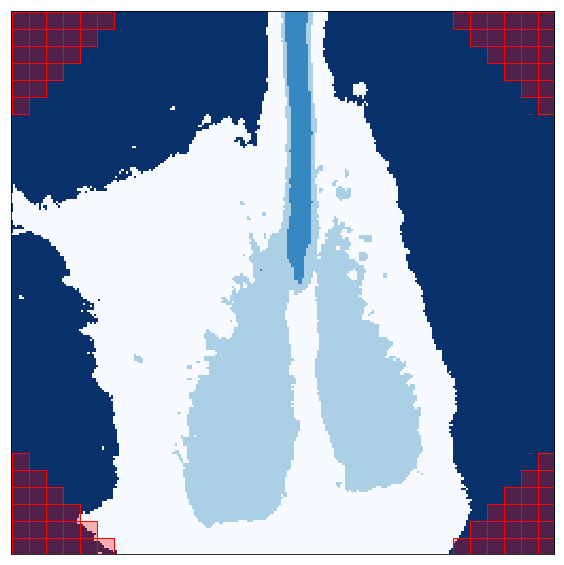

In [144]:
fig, ax1 = plt.subplots(1,1, figsize=(10, 10))
ax1.imshow(clusters, cmap = 'Blues')
pointlist = []
for pair in squares16byrange[(40, 41)]:
    for point in pair:
        if point in pointlist:
            pass
        else:
            ax1.add_patch(patches.Rectangle((squares16dict[point][0]*8,
                                             squares16dict[point][1]*8),
                                            8,8,linewidth=1,edgecolor='r',facecolor=(1,0,0,0.3)))
            pointlist.append(point)

plt.xticks([])
plt.yticks([])
plt.savefig('big-distances.png')
plt.show()

Check the cluster points shape

In [44]:
len(clusters[0])

256

Function from the other notebook which separates an image into squares

In [45]:
def get_squares(image, size=16, image_size=256):
    squares = []
    i = 0
    while i < image_size:
        j = 0
        while j < image_size:
            squares.append([row[j:j+size] for row in image[i:i+size]])
            j += size
        i += size
    return squares

Get squares from the cluster data

In [46]:
cluster_squares = get_squares(clusters, size=8)

In [47]:
len(cluster_squares)

1024

Check that the squares look reasonable on the borders, 17th square is middle of first row, should include surroundings on the left, some outer SCN and the ventricle 

In [48]:
cluster_squares[17]

[array([2, 2, 2, 2, 1, 1, 0, 0]),
 array([2, 2, 2, 2, 1, 1, 0, 0]),
 array([2, 2, 2, 2, 1, 1, 0, 0]),
 array([2, 2, 2, 2, 1, 1, 0, 0]),
 array([2, 2, 2, 2, 1, 1, 0, 0]),
 array([2, 2, 2, 2, 1, 1, 0, 0]),
 array([2, 2, 2, 1, 1, 1, 0, 0]),
 array([2, 2, 2, 1, 1, 0, 0, 0])]

Assign a cluster to each 16x16 square; the cluster is assigned if half or more of the pixels belong to that cluster

In [49]:
def squares_by_clusters(cluster_squares):
    squares_by_clusters_dict = {i: 4 for i in range(len(cluster_squares))}
    for i in range(len(cluster_squares)):
        cluster_square_counter = Counter([item for
                                          sublist in cluster_squares[i] for
                                          item in sublist])
        for cluster in cluster_square_counter:
            if cluster_square_counter[cluster] >= 32:
                squares_by_clusters_dict[i] = cluster
    return squares_by_clusters_dict

In [50]:
clusters16dict = squares_by_clusters(cluster_squares=cluster_squares)

Inspect the result visually

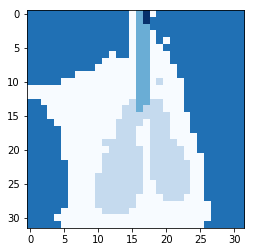

In [52]:
fig, ax1 = plt.subplots(1,1)
ax1.imshow(np.array([clusters16dict[k] for k in sorted(clusters16dict)]).reshape(-1, 32), cmap = 'Blues')
# ax1.set_title('Cluster Image')
plt.show()

For each cluster, get all squares that belong to that cluster

In [53]:
def numbers_by_clusters(clusters_squares):
    cluster_list = [clusters_squares[k] for k in sorted(clusters_squares)]
    numbers_by_clusters_dict = {i: [] for i in range(max(cluster_list) + 1)}
    for i, cl in enumerate(cluster_list):
        numbers_by_clusters_dict[cl].append(i)
    return numbers_by_clusters_dict

In [54]:
numbersbyclusters16 = numbers_by_clusters(clusters16dict)

#### Distances within cluster 0 (outer SCN)

In [55]:
squares = numbersbyclusters16[0]
cluster0dict = {s: squares16dict[s] for s in squares}

In [56]:
cluster0distances = distances_dictionary(cluster0dict)

In [57]:
cluster0byrange = pairs_per_range(cluster0distances)

In [58]:
start = time()
cluster0averages = average_per_range(df=squares16df,
                                     pairs_per_range_dict=cluster0byrange,
                                     pointdict=cluster0dict)
print(time() - start)

(1, 2) (10, 11) (21, 22) (23, 24) (25, 26) (5, 6) (33, 34) (28, 29) (8, 9) (22, 23) (2, 3) (13, 14) (29, 30) (3, 4) (11, 12) (19, 20) (18, 19) (16, 17) (0, 1) (9, 10) 

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(6, 7) (12, 13) (17, 18) (27, 28) (24, 25) (15, 16) (30, 31) (4, 5) (14, 15) (31, 32) (20, 21) (7, 8) (26, 27) (32, 33) 60.870147943496704


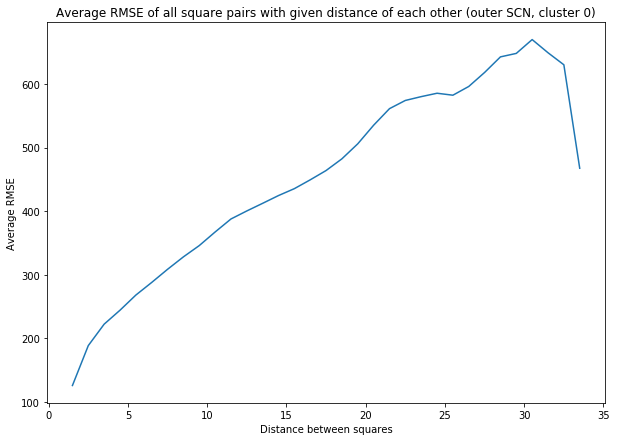

In [60]:
plt.figure(figsize=(10,7))
plt.plot([np.mean(key) for key in sorted(cluster0averages)], [cluster0averages[key] for key in sorted(cluster0averages)])
plt.title('Average RMSE of all square pairs with given distance of each other (outer SCN, cluster 0)')
plt.xlabel('Distance between squares')
plt.ylabel('Average RMSE')
plt.show()

In [501]:
start = time()
cluster0medians = median_per_range(df=squares16df,
                                     pairs_per_range_dict=cluster0byrange,
                                     pointdict=cluster0dict)
print(time() - start)

(1, 2) (10, 11) (21, 22) (23, 24) (25, 26) (5, 6) (33, 34) (28, 29) (8, 9) (22, 23) (2, 3) (13, 14) (29, 30) (3, 4) (11, 12) (19, 20) (18, 19) (16, 17) (0, 1) (9, 10) 

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(6, 7) (12, 13) (17, 18) (27, 28) (24, 25) (15, 16) (30, 31) (4, 5) (14, 15) (31, 32) (20, 21) (7, 8) (26, 27) (32, 33) 52.74589967727661


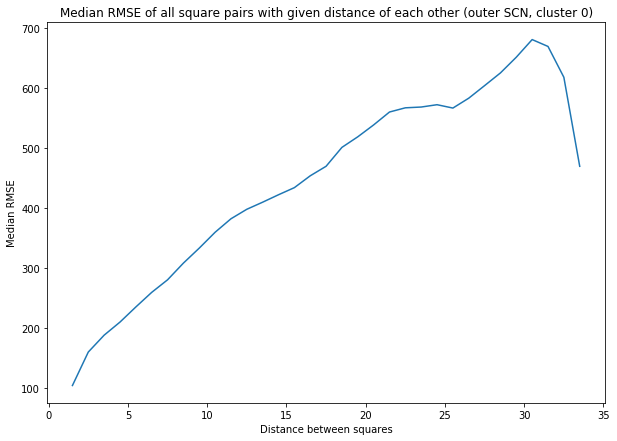

In [502]:
plt.figure(figsize=(10,7))
plt.plot([np.mean(key) for key in sorted(cluster0medians)], [cluster0medians[key] for key in sorted(cluster0medians)])
plt.title('Median RMSE of all square pairs with given distance of each other (outer SCN, cluster 0)')
plt.xlabel('Distance between squares')
plt.ylabel('Median RMSE')
plt.show()

Check further away points in cluster 0

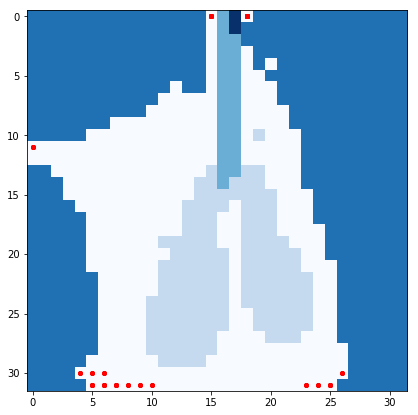

In [492]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
ax1.imshow(np.array([clusters16dict[k] for k in sorted(clusters16dict)]).reshape(-1, 32), cmap = 'Blues')
for pair in cluster0byrange[(32, 33)]:
    for point in pair:
        plt.plot(squares16dict[point][0], squares16dict[point][1], 'ro', markersize=4)
for pair in cluster0byrange[(33, 34)]:
    for point in pair:
        plt.plot(squares16dict[point][0], squares16dict[point][1], 'ro', markersize=4)
plt.show()

#### Distances within cluster 1 (inner SCN)

In [64]:
squares1 = numbersbyclusters16[1]
cluster1dict = {s: squares16dict[s] for s in squares1}

In [65]:
cluster1distances = distances_dictionary(cluster1dict)

In [66]:
cluster1byrange = pairs_per_range(cluster1distances)

In [67]:
start = time()
cluster1averages = average_per_range(df=squares16df,
                                     pairs_per_range_dict=cluster1byrange,
                                     pointdict=cluster1dict)
print(time() - start)

(0, 1) (1, 2) 

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(10, 11) (17, 18) (5, 6) (7, 8) (12, 13) (11, 12) (15, 16) (8, 9) (4, 5) (2, 3) (13, 14) (20, 21) (14, 15) (6, 7) (9, 10) (3, 4) (19, 20) (18, 19) (16, 17) 11.158151388168335


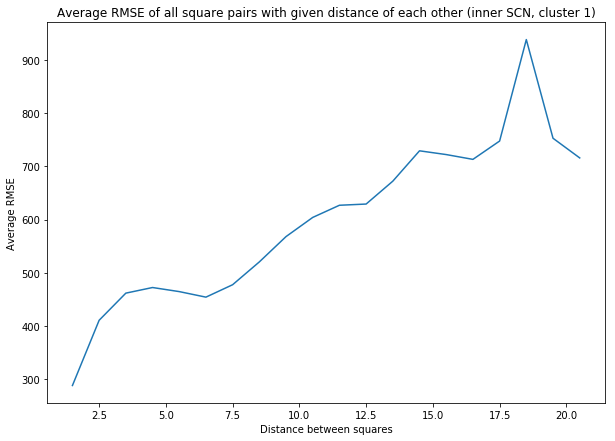

In [68]:
plt.figure(figsize=(10,7))
plt.plot([np.mean(key) for key in sorted(cluster1averages)], [cluster1averages[key] for key in sorted(cluster1averages)])
plt.title('Average RMSE of all square pairs with given distance of each other (inner SCN, cluster 1)')
plt.xlabel('Distance between squares')
plt.ylabel('Average RMSE')
plt.show()

In [503]:
start = time()
cluster1medians = median_per_range(df=squares16df,
                                     pairs_per_range_dict=cluster1byrange,
                                     pointdict=cluster1dict)
print(time() - start)

(0, 1) (1, 2) 

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(10, 11) (17, 18) (5, 6) (7, 8) (12, 13) (11, 12) (15, 16) (8, 9) (4, 5) (2, 3) (13, 14) (20, 21) (14, 15) (6, 7) (9, 10) (3, 4) (19, 20) (18, 19) (16, 17) 7.824071407318115


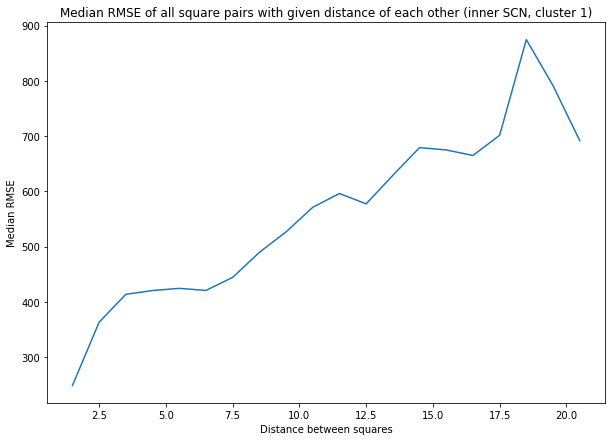

In [504]:
plt.figure(figsize=(10,7))
plt.plot([np.mean(key) for key in sorted(cluster1medians)], [cluster1medians[key] for key in sorted(cluster1medians)])
plt.title('Median RMSE of all square pairs with given distance of each other (inner SCN, cluster 1)')
plt.xlabel('Distance between squares')
plt.ylabel('Median RMSE')
plt.show()

#### Distances within cluster 1 without the outside square

In [495]:
squares1cont = numbersbyclusters16[1][1:]
cluster1contdict = {s: squares16dict[s] for s in squares1cont}

In [496]:
cluster1contdistances = distances_dictionary(cluster1contdict)

In [497]:
cluster1contbyrange = pairs_per_range(cluster1contdistances)

In [498]:
start = time()
cluster1contaverages = average_per_range(df=squares16df,
                                     pairs_per_range_dict=cluster1contbyrange,
                                     pointdict=cluster1contdict)
print(time() - start)

(0, 1) (1, 2) 

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(10, 11) (17, 18) (5, 6) (7, 8) (12, 13) (11, 12) (15, 16) (8, 9) (4, 5) (2, 3) (13, 14) (14, 15) (6, 7) (9, 10) (3, 4) (16, 17) 9.074725151062012


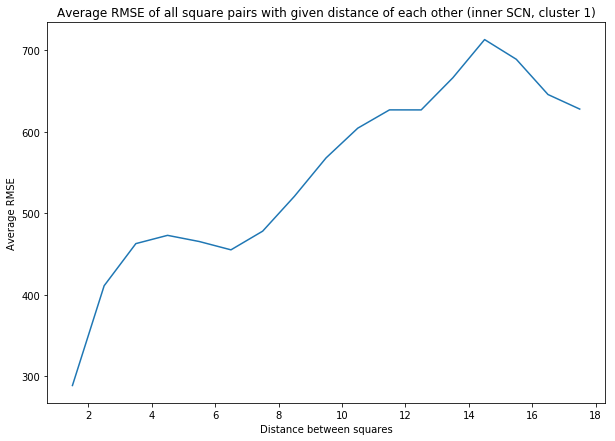

In [499]:
plt.figure(figsize=(10,7))
plt.plot([np.mean(key) for key in sorted(cluster1contaverages)], [cluster1contaverages[key] for key in sorted(cluster1contaverages)])
plt.title('Average RMSE of all square pairs with given distance of each other (inner SCN, cluster 1)')
plt.xlabel('Distance between squares')
plt.ylabel('Average RMSE')
plt.show()

#### Distances within cluster 2 (ventricle)

In [69]:
squares2 = numbersbyclusters16[2]
cluster2dict = {s: squares16dict[s] for s in squares2}

In [70]:
cluster2distances = distances_dictionary(cluster2dict)

In [71]:
cluster2byrange = pairs_per_range(cluster2distances)

In [72]:
start = time()
cluster2averages = average_per_range(df=squares16df,
                                     pairs_per_range_dict=cluster2byrange,
                                     pointdict=cluster2dict)
print(time() - start)

(0, 1) (1, 2) (10, 11) (5, 6) (7, 8) 

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(12, 13) (11, 12) (8, 9) (4, 5) (2, 3) (13, 14) (14, 15) (6, 7) (9, 10) (3, 4) 0.6602318286895752


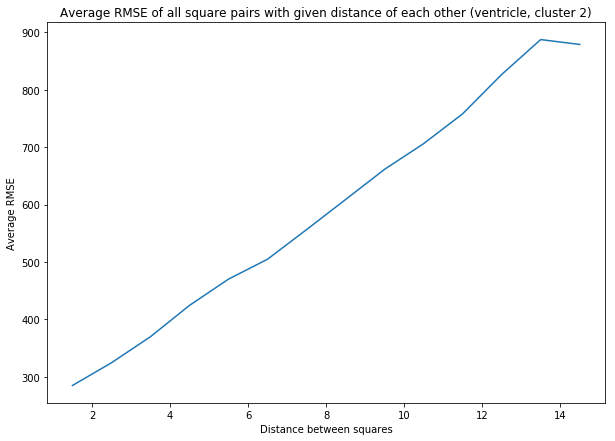

In [73]:
plt.figure(figsize=(10,7))
plt.plot([np.mean(key) for key in sorted(cluster2averages)], [cluster2averages[key] for key in sorted(cluster2averages)])
plt.title('Average RMSE of all square pairs with given distance of each other (ventricle, cluster 2)')
plt.xlabel('Distance between squares')
plt.ylabel('Average RMSE')
plt.show()

#### Distances within cluster 3 (surroundings)

In [74]:
squares3 = numbersbyclusters16[3]
cluster3dict = {s: squares16dict[s] for s in squares3}

In [75]:
cluster3distances = distances_dictionary(cluster3dict)

In [76]:
cluster3byrange = pairs_per_range(cluster3distances)

In [77]:
start = time()
cluster3averages = average_per_range(df=squares16df,
                                     pairs_per_range_dict=cluster3byrange,
                                     pointdict=cluster3dict)
print(time() - start)

(7, 8) (10, 11) (40, 41) (39, 40) (5, 6) (8, 9) (18, 19) (22, 23) (31, 32) (19, 20) (1, 2) (6, 7) (12, 13) (11, 12) (27, 28) (25, 26) (28, 29) (4, 5) (0, 1) (20, 21) 

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(35, 36) (36, 37) (32, 33) (16, 17) (42, 43) (29, 30) (15, 16) (9, 10) (2, 3) (26, 27) (37, 38) (23, 24) (33, 34) (41, 42) (38, 39) (21, 22) (17, 18) (24, 25) (13, 14) (14, 15) (43, 44) (30, 31) (3, 4) (34, 35) 115.22176718711853


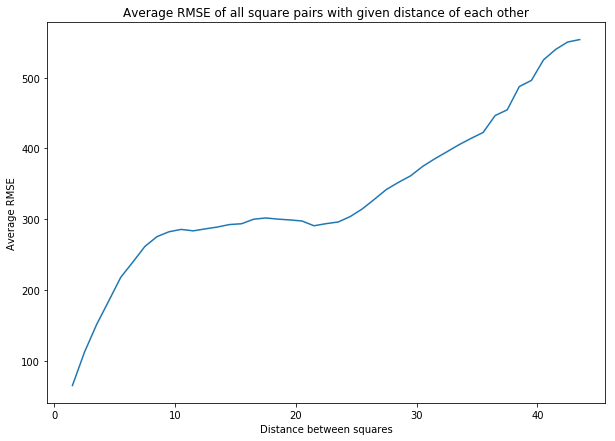

In [78]:
plt.figure(figsize=(10,7))
plt.plot([np.mean(key) for key in sorted(cluster3averages)], [cluster3averages[key] for key in sorted(cluster3averages)])
plt.title('Average RMSE of all square pairs with given distance of each other')
plt.xlabel('Distance between squares')
plt.ylabel('Average RMSE')
plt.show()

### Distances within 4 clusters visualized together

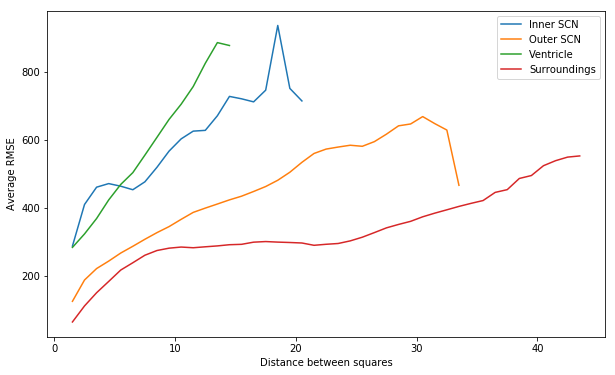

In [101]:
plt.figure(figsize=(10,6))
plt.plot([np.mean(key) for key in sorted(cluster1averages)], [cluster1averages[key] for key in sorted(cluster1averages)], label='Inner SCN')
plt.plot([np.mean(key) for key in sorted(cluster0averages)], [cluster0averages[key] for key in sorted(cluster0averages)], label='Outer SCN')
plt.plot([np.mean(key) for key in sorted(cluster2averages)], [cluster2averages[key] for key in sorted(cluster2averages)], label='Ventricle')
plt.plot([np.mean(key) for key in sorted(cluster3averages)], [cluster3averages[key] for key in sorted(cluster3averages)], label='Surroundings')
# plt.title('Average RMSE of all square pairs in clusters with distance within a given range')
plt.xlabel('Distance between squares')
plt.ylabel('Average RMSE')
plt.legend()

plt.savefig('rmse-per-cluster.png')
plt.show()

# Time mod 24 prediction

## Predicting by squares means

Make a new dataframe without the unnecessary columns

In [180]:
predsquares16df = squares16df.drop(['Image.No.', 'Frame.No', 'path', 'loaded', 'mean_intensity', 'std_intensity'], axis=1)

In [181]:
predsquares16df.head()

,Time.hrs.,mean_sq0,mean_sq1,mean_sq2,mean_sq3,mean_sq4,mean_sq5,mean_sq6,mean_sq7,mean_sq8,...,mean_sq1014,mean_sq1015,mean_sq1016,mean_sq1017,mean_sq1018,mean_sq1019,mean_sq1020,mean_sq1021,mean_sq1022,mean_sq1023
0,3.750892,1713.804688,1755.683594,1786.824219,1795.957031,1895.996094,1902.960938,1915.835938,1922.406250,1970.527344,...,2511.117188,2483.660156,2432.089844,2423.089844,2425.386719,2284.121094,2261.871094,2293.031250,2167.734375,2123.457031
1,3.846050,1667.105469,1702.195312,1743.519531,1744.703125,1845.398438,1844.910156,1859.921875,1869.488281,1927.914062,...,2491.675781,2465.074219,2417.628906,2409.375000,2396.800781,2256.851562,2240.300781,2271.394531,2143.828125,2097.484375
2,3.946050,1641.464844,1676.917969,1719.128906,1711.695312,1809.792969,1815.007812,1830.867188,1836.640625,1892.210938,...,2505.089844,2474.414062,2421.132812,2410.882812,2400.734375,2257.105469,2244.863281,2276.769531,2148.519531,2100.277344
3,4.046050,1594.101562,1632.632812,1666.039062,1674.906250,1765.410156,1764.589844,1781.234375,1788.152344,1838.632812,...,2476.203125,2455.855469,2396.984375,2384.699219,2381.550781,2234.535156,2213.925781,2251.421875,2121.406250,2076.019531
4,4.146050,1584.234375,1622.046875,1657.960938,1656.925781,1750.480469,1748.570312,1761.894531,1767.906250,1812.820312,...,2483.917969,2463.121094,2415.062500,2399.242188,2387.968750,2246.507812,2223.867188,2251.546875,2127.738281,2079.640625


We want to predict time mod 24

In [182]:
predsquares16df['time_of_day'] = predsquares16df['Time.hrs.'] % 24
predsquares16df = predsquares16df.drop('Time.hrs.', axis=1)

In [183]:
predsquares16df.tail()

,mean_sq0,mean_sq1,mean_sq2,mean_sq3,mean_sq4,mean_sq5,mean_sq6,mean_sq7,mean_sq8,mean_sq9,...,mean_sq1015,mean_sq1016,mean_sq1017,mean_sq1018,mean_sq1019,mean_sq1020,mean_sq1021,mean_sq1022,mean_sq1023,time_of_day
1680,2690.363281,2710.054688,2748.121094,2716.312500,2720.257812,2706.292969,2716.910156,2750.265625,2754.488281,2781.398438,...,2741.519531,2689.464844,2552.894531,2502.539062,2450.441406,2399.863281,2338.707031,2270.875000,2216.453125,3.616306
1681,2695.433594,2722.250000,2745.191406,2718.187500,2726.070312,2704.847656,2721.574219,2745.378906,2764.007812,2780.960938,...,2746.800781,2688.480469,2555.894531,2507.753906,2463.945312,2403.550781,2337.851562,2273.355469,2226.175781,3.716306
1682,2694.406250,2718.902344,2741.273438,2718.859375,2722.414062,2707.074219,2720.187500,2751.296875,2753.800781,2773.933594,...,2746.105469,2686.972656,2554.828125,2499.882812,2459.394531,2403.164062,2334.429688,2273.386719,2221.156250,3.816306
1683,2692.414062,2710.628906,2744.882812,2720.308594,2719.769531,2703.921875,2717.316406,2749.761719,2754.652344,2783.589844,...,2735.906250,2679.070312,2548.769531,2503.203125,2452.222656,2402.175781,2329.589844,2272.710938,2215.453125,3.916306
1684,2689.351562,2715.179688,2743.390625,2718.046875,2720.464844,2706.816406,2713.003906,2748.898438,2756.472656,2781.355469,...,2740.183594,2680.558594,2558.238281,2497.074219,2454.054688,2397.527344,2327.164062,2274.843750,2219.972656,4.016306


Train-test split

In [184]:
train, test = train_test_split(predsquares16df, test_size=0.2, random_state=0)

Check the shapes

In [185]:
train.shape

(1348, 1025)

In [186]:
test.shape

(337, 1025)

In [187]:
X_train, Y_train = train.drop('time_of_day', axis=1), train.time_of_day
X_test, Y_test = test.drop('time_of_day', axis=1), test.time_of_day

Trying some random parameters

In [539]:
regr = RandomForestRegressor(max_depth=5, random_state=0,
                             n_estimators=100)
regr.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [544]:
preds_train = regr.predict(X_train)

In [545]:
rmse(preds_train, Y_train)

2.4293499085986059

In [546]:
preds_test = regr.predict(X_test)

In [547]:
rmse(preds_test, Y_test)

2.9326068192359069

In [569]:
regr1 = RandomForestRegressor(max_depth=7, random_state=0, n_estimators=200)
regr1.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [570]:
preds1_train = regr1.predict(X_train)

In [571]:
rmse(preds1_train, Y_train)

1.4811730401891428

In [572]:
preds1_test = regr1.predict(X_test)

In [573]:
rmse(preds1_test, Y_test)

2.0622694944004283

### Grid search

In [577]:
rfregr = RandomForestRegressor()

In [575]:
param_grid = [{'n_estimators': [50, 75, 100, 150, 200, 250, 300], 'max_depth': [1, 2, 3, 5, 7, 10],
               'min_samples_leaf': [1, 2, 5, 7], 'random_state': [0]}]

In [579]:
gss = GridSearchCV(rfregr, param_grid, cv=5)

In [580]:
# this takes very long
gss.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [1, 2, 3, 5, 7, 10], 'n_estimators': [50, 75, 100, 150, 200, 250, 300], 'min_samples_leaf': [1, 2, 5, 7], 'random_state': [0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Check best params found by gridsearch

In [584]:
gss.best_params_

{'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 50, 'random_state': 0}

In [585]:
regrbest = RandomForestRegressor(max_depth=10, min_samples_leaf=1, n_estimators=50, random_state=0)

In [586]:
regrbest.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [587]:
predsbest_train = regrbest.predict(X_train)

In [592]:
rmse(predsbest_train, Y_train)

0.94469948081765409

In [593]:
predsbest_test = regrbest.predict(X_test)

In [594]:
rmse(predsbest_test, Y_test)

1.6366823578186889

### Best model we got (100 estimators, depth 15)

In [667]:
mypreds_train = myregr.predict(X_train)
rmse(mypreds_train, Y_train)

0.78044089555559193

In [668]:
mypreds_test = myregr.predict(X_test)
rmse(mypreds_test, Y_test)

1.557930762857346

Use RMSE_time to evaluate; it's the same as RMSE on train, but lower on test

In [669]:
rmse_time(mypreds_train, Y_train)

0.78044089555559193

In [670]:
rmse_time(mypreds_test, Y_test)

1.0636466085778533

Examine fature importance

In [671]:
importances = myregr.feature_importances_

In [675]:
importances = myregr.feature_importances_
std = np.std([tree.feature_importances_ for tree in myregr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
# print("Feature ranking:")

# for f in range(X_train.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 878 (0.151603)
2. feature 910 (0.119279)
3. feature 908 (0.108346)
4. feature 808 (0.041265)
5. feature 620 (0.028892)
6. feature 755 (0.026627)
7. feature 820 (0.024153)
8. feature 807 (0.022874)
9. feature 909 (0.012035)
10. feature 749 (0.010834)

### Locations of most important features

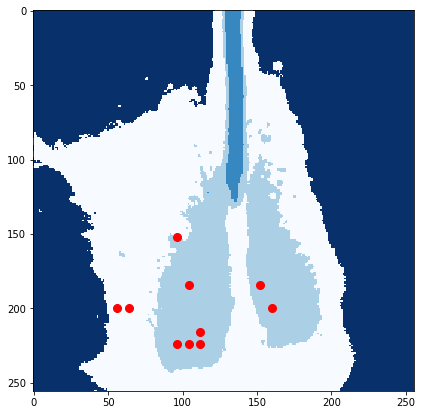

In [689]:
fig, ax1 = plt.subplots(1,1, figsize=(7, 7))
ax1.imshow(clusters, cmap = 'Blues')
for point in [878, 910, 908, 808, 620, 755, 820, 807, 909, 749]:
    plt.plot(squares16dict[point][0]*8, squares16dict[point][1]*8, 'ro', markersize=8)
# ax1.set_title('Cluster Image')
plt.show()

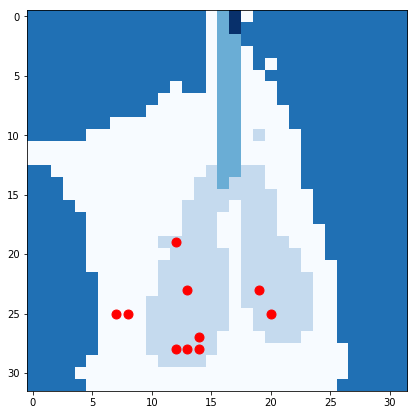

In [683]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
ax1.imshow(np.array([clusters16dict[k] for k in sorted(clusters16dict)]).reshape(-1, 32), cmap = 'Blues')
for point in [878, 910, 908, 808, 620, 755, 820, 807, 909, 749]:
    plt.plot(squares16dict[point][0], squares16dict[point][1], 'ro', markersize=9)
plt.show()

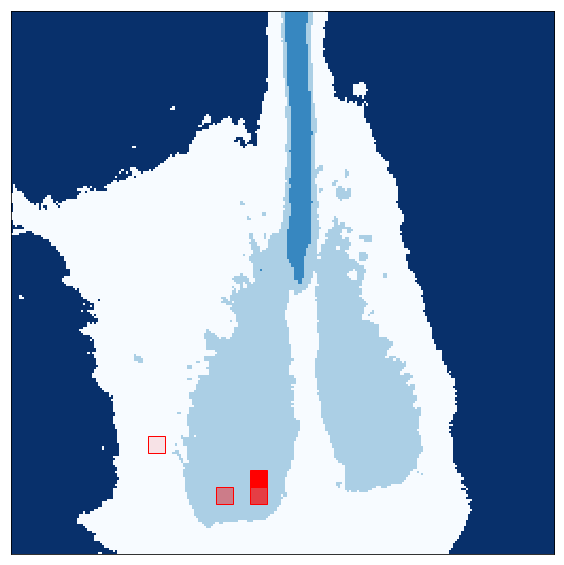

In [272]:
fig, ax1 = plt.subplots(1,1, figsize=(10, 10))
ax1.imshow(clusters, cmap = 'Blues')
pointlist = []
opacity = 1
for point in [878, 910, 908, 808]:#, 620, 755, 820, 807, 909, 749]:
    ax1.add_patch(patches.Rectangle((squares16dict[point][0]*8,
                                             squares16dict[point][1]*8),
                                            8,8,linewidth=1,edgecolor='r',facecolor=(1,0,0,opacity)))
    opacity -= 0.3

plt.xticks([])
plt.yticks([])
plt.savefig('feature-importance.png')
plt.show()

### Some more random poking

In [601]:
myregr = RandomForestRegressor(max_depth=15, min_samples_leaf=1, n_estimators=50, random_state=0)

In [602]:
myregr.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [603]:
mypreds_train = myregr.predict(X_train)
rmse(mypreds_train, Y_train)

0.82612945028230855

In [604]:
mypreds_test = myregr.predict(X_test)
rmse(mypreds_test, Y_test)

1.5395968785154628

In [613]:
myregr = RandomForestRegressor(max_depth=15, min_samples_leaf=1, n_estimators=60, random_state=0)

In [614]:
myregr.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [615]:
mypreds_train = myregr.predict(X_train)
rmse(mypreds_train, Y_train)

0.79741994379820857

In [616]:
mypreds_test = myregr.predict(X_test)
rmse(mypreds_test, Y_test)

1.5588732282844551

In [220]:
myregr = RandomForestRegressor(max_depth=15, min_samples_leaf=1, n_estimators=75, random_state=0)

In [221]:
myregr.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [222]:
mypreds_train = myregr.predict(X_train)
rmse(mypreds_train, Y_train)

0.84223579145865723

In [223]:
rmse_time(mypreds_train, Y_train)

0.84223579145865723

In [214]:
mypreds_test = myregr.predict(X_test)
rmse(mypreds_test, Y_test)

1.4760726290495614

In [215]:
rmse_time(mypreds_test, Y_test)

1.4760726290495614

In [197]:
importances = myregr.feature_importances_
std = np.std([tree.feature_importances_ for tree in myregr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# # Print the feature ranking
# print("Feature ranking:")

# for f in range(X_train.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

## Predicting by cluster means

In [156]:
predsquares16df.head()

,mean_sq0,mean_sq1,mean_sq2,mean_sq3,mean_sq4,mean_sq5,mean_sq6,mean_sq7,mean_sq8,mean_sq9,...,mean_sq1015,mean_sq1016,mean_sq1017,mean_sq1018,mean_sq1019,mean_sq1020,mean_sq1021,mean_sq1022,mean_sq1023,time_of_day
0,1713.804688,1755.683594,1786.824219,1795.957031,1895.996094,1902.960938,1915.835938,1922.406250,1970.527344,1964.246094,...,2483.660156,2432.089844,2423.089844,2425.386719,2284.121094,2261.871094,2293.031250,2167.734375,2123.457031,3.750892
1,1667.105469,1702.195312,1743.519531,1744.703125,1845.398438,1844.910156,1859.921875,1869.488281,1927.914062,1924.750000,...,2465.074219,2417.628906,2409.375000,2396.800781,2256.851562,2240.300781,2271.394531,2143.828125,2097.484375,3.846050
2,1641.464844,1676.917969,1719.128906,1711.695312,1809.792969,1815.007812,1830.867188,1836.640625,1892.210938,1894.734375,...,2474.414062,2421.132812,2410.882812,2400.734375,2257.105469,2244.863281,2276.769531,2148.519531,2100.277344,3.946050
3,1594.101562,1632.632812,1666.039062,1674.906250,1765.410156,1764.589844,1781.234375,1788.152344,1838.632812,1848.570312,...,2455.855469,2396.984375,2384.699219,2381.550781,2234.535156,2213.925781,2251.421875,2121.406250,2076.019531,4.046050
4,1584.234375,1622.046875,1657.960938,1656.925781,1750.480469,1748.570312,1761.894531,1767.906250,1812.820312,1827.644531,...,2463.121094,2415.062500,2399.242188,2387.968750,2246.507812,2223.867188,2251.546875,2127.738281,2079.640625,4.146050


In [162]:
with open('cluster_dict_0.txt', 'r', encoding='utf-8') as cld0:
    feature_cluster0 = [int(line.strip()) for line in cld0.readlines()]
with open('cluster_dict_1.txt', 'r', encoding='utf-8') as cld1:
    feature_cluster1 = [int(line.strip()) for line in cld1.readlines()]
with open('cluster_dict_2.txt', 'r', encoding='utf-8') as cld2:
    feature_cluster2 = [int(line.strip()) for line in cld2.readlines()]
with open('cluster_dict_3.txt', 'r', encoding='utf-8') as cld3:
    feature_cluster3 = [int(line.strip()) for line in cld3.readlines()]

Note that the cluster numbers do not match the pixel-by-cluster file

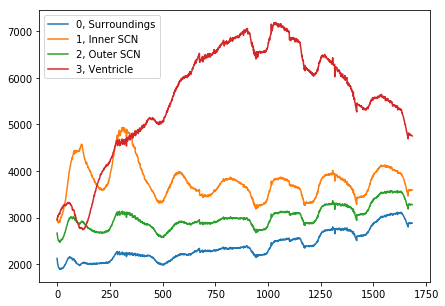

In [171]:
plt.figure(figsize=(7,5))
plt.plot(list(range(1685)), feature_cluster0, label='0, Surroundings')
plt.plot(list(range(1685)), feature_cluster1, label='1, Inner SCN')
plt.plot(list(range(1685)), feature_cluster2, label='2, Outer SCN')
plt.plot(list(range(1685)), feature_cluster3, label='3, Ventricle')
plt.legend()
plt.show()

In [172]:
clusterspreddf = pd.DataFrame(data={'time_of_day': predsquares16df.time_of_day,
                                    'inner': feature_cluster1,
                                    'outer': feature_cluster2,
                                    'ventricle': feature_cluster3,
                                    'surroundings': feature_cluster0})

In [173]:
clusterspreddf.head()

,inner,outer,surroundings,time_of_day,ventricle
0,2970,2668,2124,3.750892,2951
1,2945,2626,2079,3.846050,2970
2,2944,2610,2053,3.946050,3009
3,2912,2566,2006,4.046050,3009
4,2914,2552,1988,4.146050,3025


In [224]:
cl_train, cl_test = train_test_split(clusterspreddf, test_size=0.2, random_state=0)

In [225]:
cl_train.shape

(1348, 5)

In [226]:
cl_test.shape

(337, 5)

In [228]:
X_cl_train, Y_cl_train = cl_train.drop('time_of_day', axis=1), cl_train.time_of_day
X_cl_test, Y_cl_test = cl_test.drop('time_of_day', axis=1), cl_test.time_of_day

In [254]:
clregr = RandomForestRegressor(max_depth=5, min_samples_leaf=1, n_estimators=20, random_state=0)

In [255]:
clregr.fit(X_cl_train, Y_cl_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [256]:
clpreds_train = clregr.predict(X_cl_train)
rmse(clpreds_train, Y_cl_train)

3.2781778051398596

In [250]:
rmse_time(clpreds_train, Y_cl_train)

1.1560913138710205

In [239]:
clpreds_test = clregr.predict(X_cl_test)
rmse(clpreds_test, Y_cl_test)

1.9986777871476478

In [669]:
rmse_time(clpreds_train, Y_train)

0.78044089555559193

In [670]:
rmse_time(clpreds_test, Y_test)

1.0636466085778533

In [257]:
rfregr = RandomForestRegressor()

In [258]:
param_grid = [{'n_estimators': [5, 10, 20, 25, 30, 40, 50, 75, 100, 150, 200],
               'max_depth': [1, 2, 3, 5, 7, 10, 15, 20, 30],
               'min_samples_leaf': [1, 2, 5, 7], 'random_state': [0]}]

In [259]:
gss_cl = GridSearchCV(rfregr, param_grid, cv=5)

In [261]:
gss_cl.fit(X_cl_train, Y_cl_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'random_state': [0], 'max_depth': [1, 2, 3, 5, 7, 10, 15, 20, 30], 'n_estimators': [5, 10, 20, 25, 30, 40, 50, 75, 100, 150, 200], 'min_samples_leaf': [1, 2, 5, 7]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [263]:
gss_cl.best_params_

{'max_depth': 15,
 'min_samples_leaf': 1,
 'n_estimators': 100,
 'random_state': 0}

In [264]:
myclregr = RandomForestRegressor(max_depth=15, min_samples_leaf=1,
                                 n_estimators=100, random_state=0)

In [265]:
myclregr.fit(X_cl_train, Y_cl_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [266]:
myclpreds_train = myclregr.predict(X_cl_train)
rmse(myclpreds_train, Y_cl_train)

0.84411886403787939

In [267]:
rmse_time(myclpreds_train, Y_cl_train)

0.84411886403787939

In [269]:
myclpreds_test = myclregr.predict(X_cl_test)
rmse_time(myclpreds_test, Y_cl_test)

1.9365324092713794